
## Goal
In this project you will create a data pipeline that ingests wather warnings
 
Input:
https://alerts.weather.gov/cap/us.php?x=0
fips6 location codes to translate warining location into region, state and county
 
Create a bronze delta table to where every batch of data is appended
Create a silver delta table where waning data is merge
Create a gold delta table where warning location is enriched

The pipeline should both consider initial and incremental loads
 
Create some visuals (charts) to analyse the data :
Some examples:
- Counts by state, county, date, type of alert
- What alerts are currently active

### Dataflows
get alerts, get fips -> select and filters alerts -> marge datasets geocode

## Leitura dos dados em Weather Alerts

In [ ]:
import requests
import datetime, time

url = "https://alerts.weather.gov/cap/us.php?x=0"
alerts_path="/FileStore/tables/weather"

# Fetch 
response = requests.get(url)
xml_data = response.content


def weather_alerts(url_to_download,path_to_write):
    
    data_xml = requests.get(url_to_download).content

    filename_to_write='weather_alerts-{date:%Y-%m-%d_%H:%M:%S}.txt'.format( date=datetime.datetime.now() )
    path_to_write=path_to_write+"/"+filename_to_write

    alerts_file = dbutils.fs.put(path_to_write, str(data_xml))

    return alerts_file

alerts_file = weather_alerts(url, alerts_path)


Wrote 2077729 bytes.


### XML para Dataframe Spark

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df_alerts = spark.read.option("rowTag", "entry").format("xml").load(alerts_path)


## Tabela FIP

In [ ]:
## Dados FIPs
from io import StringIO
import pandas as pd

def fetch_and_process_fips_csv(url):
    # Requisição HTTP
    response = requests.get(url)
    
    # Ler o conteúdo da resposta como um DataFrame
    df = pd.read_csv(StringIO(response.text))
    
    fips_df = df.copy()
    fips_df = fips_df[['fips_code', 'name','lng','lat']]
    fips_df = fips_df.rename(columns={'fips_code': 'FIPS', 'name': 'NAME'})
    
    return fips_df



In [ ]:
# URL do arquivo CSV
url = "https://gist.githubusercontent.com/russellsamora/12be4f9f574e92413ea3f92ce1bc58e6/raw/3f18230058afd7431a5d394dab7eeb0aafd29d81/us_county_latlng.csv"

# Obter os DataFrames
fips_df = fetch_and_process_fips_csv(url)

In [ ]:
fips_df_spark = spark.createDataFrame(fips_df)
display(fips_df_spark)

## Camada Bronze

In [ ]:
# Camada Bronze - Raw Data
bronze_path = "/FileStore/tables/weather/bronze"
fips_path="/FileStore/tables/fips"

# Salvar o DataFrame parquet
df_alerts.write.format("parquet").mode("append").save(bronze_path)
fips_df_spark.write.format("parquet").mode("overwrite").save(fips_path)


## Camada Silver

In [ ]:
# Camada Silver 
silver_path = "/FileStore/tables/weather/silver"

df_alerts_silver = spark.read.format("parquet").load(bronze_path)

# Colunas selecionadas 
silver_df_alerts = df_alerts_silver.select("id", "title", "summary", "cap:areaDesc", "cap:geocode", "cap:category", "cap:certainty", "cap:effective", "cap:event", "cap:msgType", "cap:severity", "cap:status", "cap:urgency", "published" )



### Transformações

In [ ]:
from pyspark.sql import functions as F

# Coluna temporária com os valores explodidos
exploded_df = silver_df_alerts.withColumn("geocode_exploded", F.explode("cap:geocode"))

# Filtro dos valores onde valueName é "SAME" 
result_df = exploded_df.filter(F.col("geocode_exploded.valueName") == "SAME")



In [ ]:
# Dados transformados salvo em camada silver
result_df.write.format("parquet").mode("overwrite").save(silver_path)

## Camada Gold

In [ ]:
# Camada Gold 
gold_path = "/FileStore/tables/weather/gold"


# Caminhos dos arquivos parquet
silver_path = "/FileStore/tables/weather/silver"
fips_path = "/FileStore/tables/fips"

# Leitura dos arquivos parquet em DataFrames
df_alerts_gold = spark.read.format("parquet").load(silver_path)
fips_df_spark_gold = spark.read.format("parquet").load(fips_path)


### Marge de fips com dados silver em função da coluna geocode

In [ ]:
merged_df_2 = df_alerts_gold.join(
    fips_df_spark_gold,
    df_alerts_gold.geocode_exploded.value == fips_df_spark_gold.FIPS,
    "left"
)


In [ ]:
no_duplcate = merged_df_2.dropDuplicates(['id'])
with_fips_in_df = no_duplcate.dropna(subset=['FIPS'])

display(with_fips_in_df)

In [ ]:
# Salvar o DataFrame camada gold
with_fips_in_df.write.format("parquet").mode("overwrite").save(gold_path)

In [ ]:
!pip install WordCloud
!pip install geopandas

## Visualizações


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

# Camada Gold 
gold_path = "/FileStore/tables/weather/gold"
dataframe_final = spark.read.format("parquet").load(gold_path)

# Converter o PySpark DataFrame para Pandas DataFrame
pandas_df = dataframe_final.toPandas()

In [ ]:
display(pandas_df)

In [ ]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1662 entries, 0 to 1661
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                1662 non-null   object        
 1   title             1662 non-null   object        
 2   summary           1662 non-null   object        
 3   cap:areaDesc      1662 non-null   object        
 4   cap:geocode       1662 non-null   object        
 5   cap:category      1662 non-null   object        
 6   cap:certainty     1662 non-null   object        
 7   cap:effective     1662 non-null   datetime64[ns]
 8   cap:event         1662 non-null   object        
 9   cap:msgType       1662 non-null   object        
 10  cap:severity      1662 non-null   object        
 11  cap:status        1662 non-null   object        
 12  cap:urgency       1662 non-null   object        
 13  published         1662 non-null   datetime64[ns]
 14  geocode_exploded  1662 n

In [ ]:
# Gráfico de linha temporal para eventos publicados
pandas_df['published'] = pd.to_datetime(pandas_df['published'])
events_over_time = pandas_df.groupby(pandas_df['published'].dt.date).size().reset_index(name='count')
fig3 = px.line(events_over_time, x='published', y='count', 
               title='Número de Eventos Publicados ao Longo do Tempo')
fig3.show()

In [ ]:
# Localidade dos eventos
fig1 = go.Figure(data=go.Scattergeo(
    lon = pandas_df['lng'],
    lat = pandas_df['lat'],
    text = pandas_df['NAME'],
    mode = 'markers',
))

fig1.update_layout(
    title = 'Localização dos Eventos',
    geo_scope='usa'
)

In [ ]:
fig4 = px.scatter_geo(pandas_df, 
                      lat='lat', 
                      lon='lng', 
                      color='cap:severity',
                      hover_name='NAME', 
                      size='FIPS',
                      scope='usa',
                      title='Eventos por Categoria e FIPS')

fig4.show()


In [ ]:
mapa_severidade()

In [ ]:
# Gráfico de contagem para tipos de evento com Plotly
fig = px.bar(
    pandas_df['cap:event'].value_counts().reset_index(),
    x='cap:event',
    y='index',
    labels={'index': 'Tipo de Evento', 'cap:event': 'Contagem'},
    title='Contagem de Tipos de Eventos',
    orientation='h',  # Barras horizontais
    color='index',  # Colore cada barra de acordo com o tipo de evento
    color_discrete_sequence=px.colors.sample_colorscale('Plotly3', [n / len(pandas_df['cap:event'].unique()) for n in range(len(pandas_df['cap:event'].unique()))])
)

# Atualizar o layout do gráfico
fig.update_layout(
    yaxis_title='Tipo de Evento',
    xaxis_title='Contagem',
    yaxis={'categoryorder': 'total ascending'}
)

# Mostrar o gráfico
fig.show()

In [ ]:
# Obter os 20 municípios com mais alertas
municipality_counts = pandas_df['NAME'].value_counts().nlargest(20).reset_index()
municipality_counts.columns = ['Município', 'Contagem']

# Gráfico de barras com degradê
colors = px.colors.sample_colorscale('Plotly3', [n / len(municipality_counts) for n in range(len(municipality_counts))])

fig = go.Figure(data=[
    go.Bar(
        x=municipality_counts['Contagem'],
        y=municipality_counts['Município'],
        orientation='h',
        marker=dict(
            color=municipality_counts['Contagem'],
            colorscale='Plotly3',
            colorbar=dict(title="Número de Alertas"),
        )
    )
])

fig.update_layout(
    title='Top 20 Municípios com Mais Alertas',
    xaxis_title='Número de Alertas',
    yaxis_title='Município',
    yaxis={'categoryorder':'total ascending'}  # Ordenar os municípios em ordem decrescente de alertas
)

# Mostrar o gráfico
fig.show()

In [ ]:
from datetime import datetime

# Converter a coluna 'cap:effective' para datetime
pandas_df['cap:effective'] = pd.to_datetime(pandas_df['cap:effective'])

# Obter a data e hora atual
current_time = datetime.now()

# Filtrar alertas ativos
active_alerts = pandas_df[(pandas_df['cap:status'] == 'Actual') & (pandas_df['cap:effective'] <= current_time)]

# Contar alertas ativos por tipo de evento
active_alerts_count = active_alerts['cap:event'].value_counts().reset_index()
active_alerts_count.columns = ['Tipo de Alerta', 'Contagem']

# Gráfico de barras para alertas ativos
fig = px.bar(active_alerts_count, 
             x='Tipo de Alerta', 
             y='Contagem',
             title='Alertas Ativos por Tipo',
             labels={'Contagem': 'Número de Alertas Ativos'},
             color='Tipo de Alerta')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [ ]:
# 4. Contagem por Tipo de Alerta (Plotly)
alert_type_counts = pandas_df['cap:event'].value_counts().reset_index()
alert_type_counts.columns = ['Tipo de Alerta', 'Contagem']

# Selecionar apenas os 10 primeiros tipos de alerta
alert_type_counts = alert_type_counts.head(10)

fig4 = px.pie(alert_type_counts, values='Contagem', names='Tipo de Alerta', hole=0.3,
              title='Distribuição dos 5 Principais Tipos de Alerta')
fig4.show()

### Gráfico de pizza para mostrar a distribuição de severidade

In [ ]:
# Obter as contagens de severidade
severity_counts = pandas_df['cap:severity'].value_counts()

# Criar o gráfico de pizza com Plotly
fig = go.Figure(data=[go.Pie(labels=severity_counts.index, values=severity_counts.values, hole=0.3)])

# Atualizar o layout do gráfico
fig.update_layout(
    title='Distribuição de Severidade'
)

# Mostrar o gráfico
fig.show()


### Gráfico de barras empilhadas para mostrar a relação entre urgência e status

In [ ]:
# Agrupar e contar os dados por urgência e status
urgency_status = pandas_df.groupby(['cap:urgency', 'cap:status']).size().unstack()

# Criar o gráfico de barras empilhadas com Plotly
fig = go.Figure()

for status in urgency_status.columns:
    fig.add_trace(go.Bar(
        x=urgency_status.index,
        y=urgency_status[status],
        name=status
    ))

# Atualizar o layout do gráfico
fig.update_layout(
    barmode='stack',
    title='Relação entre Urgência e Status',
    xaxis_title='Urgência',
    yaxis_title='Contagem',
    legend_title='Status'
)

# Mostrar o gráfico
fig.show()

### Nuvem de palavras dos títulos

Text(0.5, 1.0, 'Nuvem de Palavras dos Títulos')

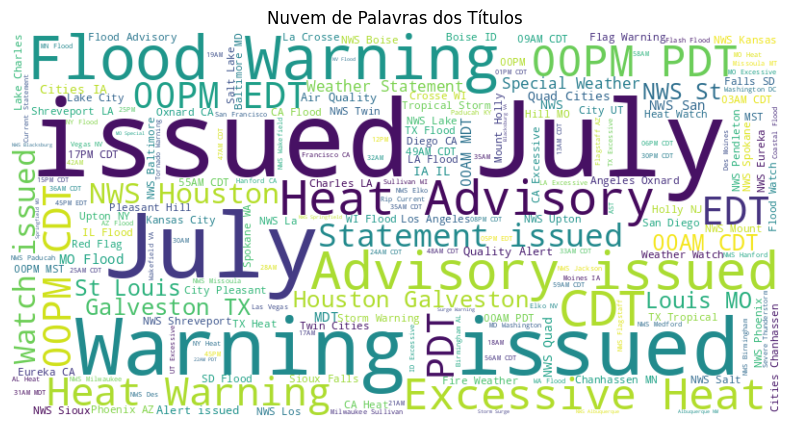

In [ ]:
from wordcloud import WordCloud

text = ' '.join(pandas_df['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras dos Títulos')

In [ ]:
# DataFrame para contagem de tipos de mensagem
msg_type_counts = pandas_df['cap:msgType'].value_counts().reset_index()
msg_type_counts.columns = ['Tipo de Mensagem', 'Contagem']

# Gráfico de contagem para tipos de mensagem com Plotly
fig = px.bar(
    msg_type_counts,
    x='Tipo de Mensagem',
    y='Contagem',
    labels={'Tipo de Mensagem': 'Tipo de Mensagem', 'Contagem': 'Contagem'},
    title='Contagem de Tipos de Mensagem',
    color='Tipo de Mensagem',  # Definir cor diferente para cada barra
    color_discrete_sequence=px.colors.qualitative.Plotly  # Escolher uma paleta de cores
)

# Atualizar o layout do gráfico
fig.update_layout(
    xaxis_title='Tipo de Mensagem',
    yaxis_title='Contagem',
    xaxis={'categoryorder':'total descending'}
)

# Mostrar o gráfico
fig.show()

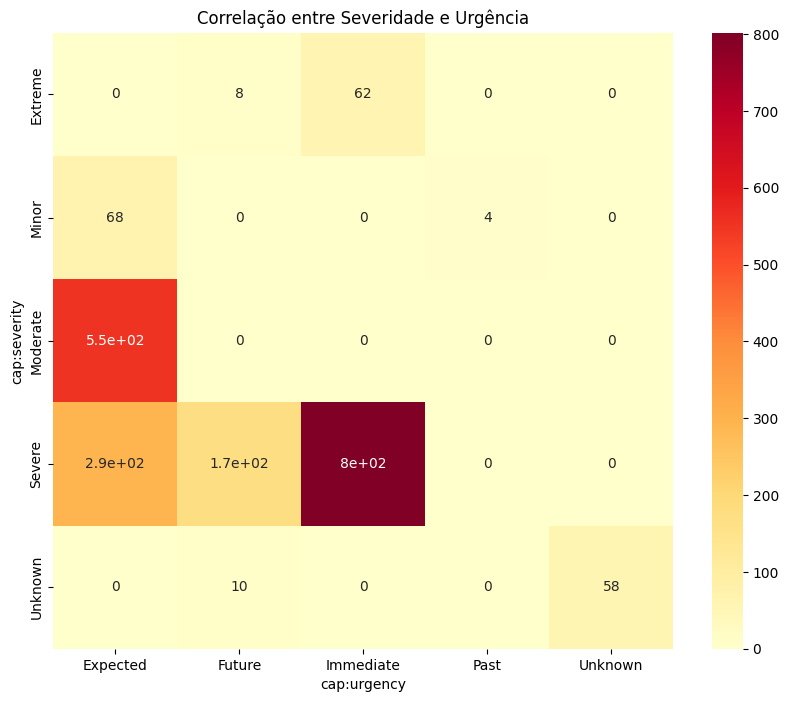

In [ ]:
# Gráfico de calor para correlação entre severidade e urgência
severity_urgency = pd.crosstab(pandas_df['cap:severity'], pandas_df['cap:urgency'])
plt.figure(figsize=(10, 8))
sns.heatmap(severity_urgency, annot=True, cmap='YlOrRd')
plt.title('Correlação entre Severidade e Urgência')
plt.show()

## Códigos de mapas

In [ ]:
def mapa_severidade():    
    # Mapeando severidade para valores numéricos
    severity_map = {'Minor': 0, 'Moderate': 1, 'Severe': 2, 'Extreme': 3}
    pandas_df['severity_value'] = pandas_df['cap:severity'].map(severity_map)

    scl = [
        [0, "rgb(150,0,90)"], [0.25, "rgb(0, 0, 200)"],
        [0.5, "rgb(0, 255, 0)"], [0.75, "rgb(255, 234, 0)"],
        [1, "rgb(255, 0, 0)"]
    ]

    fig = go.Figure(data=go.Scattergeo(
        lat = pandas_df['lat'],
        lon = pandas_df['lng'],
        text = pandas_df['cap:event'] + '<br>' + pandas_df['cap:severity'] + ' severity',
        marker = dict(
            color = pandas_df['severity_value'],
            colorscale = scl,
            reversescale = False,
            opacity = 0.7,
            size = 5,
            colorbar = dict(
                title = "Severity",
                titleside = "right",
                outlinecolor = "rgba(68, 68, 68, 0)",
                ticks = "outside",
                showticksuffix = "last",
                tickvals = [0, 1, 2, 3],
                ticktext = ['Minor', 'Moderate', 'Severe', 'Extreme']
            )
        )
    ))

    fig.update_layout(
        geo = dict(
            scope = 'usa',
            showland = True,
            landcolor = "rgb(212, 212, 212)",
            subunitcolor = "rgb(255, 255, 255)",
            countrycolor = "rgb(255, 255, 255)",
            showlakes = True,
            lakecolor = "rgb(255, 255, 255)",
            showsubunits = True,
            showcountries = True,
            resolution = 50,
            projection = dict(
                type = 'albers usa'
            ),
            lonaxis = dict(
                showgrid = True,
                gridwidth = 0.5,
                range= [ -140.0, -55.0 ],
                dtick = 5
            ),
            lataxis = dict (
                showgrid = True,
                gridwidth = 0.5,
                range= [ 20.0, 60.0 ],
                dtick = 5
            )
        ),
        title='Eventos por Severidade nos EUA<br>Fonte: Seu conjunto de dados',
    )

    # Adicionando seletor de categoria
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=list([
                    dict(label="Todos",
                        method="update",
                        args=[{"visible": [True] * len(pandas_df)}]),
                ] + [
                    dict(label=category,
                        method="update",
                        args=[{"visible": pandas_df['cap:category'] == category}])
                    for category in pandas_df['cap:category'].unique()
                ]),
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )

    fig.show()